## Import packages

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from textblob import TextBlob
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [56]:
import glob, os    
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "*.csv"))))

In [57]:
df.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2020-01-30 15:37:38,ibrahim89558604,Peruzi_VIBES,0,0,0,Kabir Ibrahim isa 5760318012 fcmb bank,NaN,NaN,NaN,1222906726107664384,https://twitter.com/ibrahim89558604/status/122...
1,2020-01-30 14:25:32,YarKafanchan,Hard_Knockks,0,0,1,"I also bank with Zenith, excellent bank. FCMB ...",NaN,NaN,NaN,1222888580105822209,https://twitter.com/YarKafanchan/status/122288...
2,2020-01-30 13:54:23,YarKafanchan,NaN,2,0,4,"After this work is done, we are moving our acc...",NaN,@MyFCMB,NaN,1222880742167973888,https://twitter.com/YarKafanchan/status/122288...
3,2020-01-30 11:34:18,IykeJeenah,obi_cubana,0,0,0,4188591010 Fcmb,NaN,NaN,NaN,1222845486845042689,https://twitter.com/IykeJeenah/status/12228454...
4,2020-01-30 11:18:31,SIjebu,obi_cubana,0,0,0,2831838019 fcmb sir,NaN,NaN,NaN,1222841515011117056,https://twitter.com/SIjebu/status/122284151501...


## Data Processing

- Drop columns not needed

In [59]:
data = df.drop(['replies', 'retweets', 'favorites', 
                'geo', 'mentions', 'id', 'permalink'], axis=1)

- Convert expected column to datetime

In [60]:
data['date'] = pd.to_datetime(data['date'])

There are a lot of giveaway tweets and I don't want to drop them because they are useful for sentiment analysis.

 For now, I have to search and drop giveaway tweets. 
 

- Drop all missing values in the text column

In [62]:
data = data.dropna(subset=['text'])

In [63]:
# first get all tweets that contains number in them. This might be 
# 3781 rows with numeric features, time to clean them and remove those tweeted for gieaway purpose


#create a mask for all the tweets with number in them.
data['cat'] = data['text'].str.contains('\d', regex=True)
numeric_data = data[data['cat']  == True]
numeric_data.shape

(3871, 6)

In [64]:
non_num = data[data['cat'] == False]
non_num.shape

(4269, 6)

In [65]:
# use to column to check for username tweeted to that are not bank names.
# first check tweeted to more than 5
# after investigation, majority of tweets contaiining numbers are giveaway tweets, dropping them as over 90% of the tweests are giveaway tweets.
#except for the tweets tweeted to banks usernames

to_use = ['ZenithBank', 'ZenithBank', 'cenbank', 'FBN_help',
          'accessbank_help', 'gtbank', 'gtbank_help', 'UBAGroup',
          'myaccessbank', 'MyFCMB', 'Sterling_Bankng', 'StanbicIBTC',
          'ChifeDr', 'THISDAYLIVE', 'Chydee', 'abc13houston', 'Mustyjaf']

numeric_data = numeric_data[numeric_data.to.isin(to_use)]
numeric_data.shape

(174, 6)

In [66]:
# concatenate the 2 data

new_data = pd.concat([non_num, numeric_data])
new_data.shape

(4443, 6)

In [67]:
new_data.head()

,date,username,to,text,hashtags,cat
1,2020-01-30 14:25:32,YarKafanchan,Hard_Knockks,"I also bank with Zenith, excellent bank. FCMB ...",NaN,False
2,2020-01-30 13:54:23,YarKafanchan,NaN,"After this work is done, we are moving our acc...",NaN,False
12,2020-01-29 15:01:24,Khalifat_ays__,NaN,"This guy followed me from FCMB to Zenith bank,...",NaN,False
18,2020-01-29 11:43:03,omidanabeni,djcuppymusic,Fcmb #AduraByCapitalTKO,#AduraByCapitalTKO,False
23,2020-01-29 06:24:10,aceshedy,volqx,Fcmb or zenith bank,NaN,False


In [68]:
#select tweets without hashtags because hashtags are used to trend stuff

new_data = new_data[new_data['hashtags'].isna()]

In [69]:
new_data.head()

,date,username,to,text,hashtags,cat
1,2020-01-30 14:25:32,YarKafanchan,Hard_Knockks,"I also bank with Zenith, excellent bank. FCMB ...",NaN,False
2,2020-01-30 13:54:23,YarKafanchan,NaN,"After this work is done, we are moving our acc...",NaN,False
12,2020-01-29 15:01:24,Khalifat_ays__,NaN,"This guy followed me from FCMB to Zenith bank,...",NaN,False
23,2020-01-29 06:24:10,aceshedy,volqx,Fcmb or zenith bank,NaN,False
24,2020-01-28 20:09:18,iam_toluine,NaN,@FBN_help hello first bank. I made a transfer ...,NaN,False


In [70]:
new_data.shape

(3794, 6)

In [71]:
# drop other columns, Only need the date and text columns

final_data = new_data[['date', 'text']]
final_data.head()

,date,text
1,2020-01-30 14:25:32,"I also bank with Zenith, excellent bank. FCMB ..."
2,2020-01-30 13:54:23,"After this work is done, we are moving our acc..."
12,2020-01-29 15:01:24,"This guy followed me from FCMB to Zenith bank,..."
23,2020-01-29 06:24:10,Fcmb or zenith bank
24,2020-01-28 20:09:18,@FBN_help hello first bank. I made a transfer ...


In [72]:
# remove all non-letter character 

final_data['text'] = final_data['text'].str.replace('[^a-zA-Z]', ' ')
final_data['text'] = final_data['text'].str.lower()

/home/godwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/godwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [73]:
final_data.head()

,date,text
1,2020-01-30 14:25:32,i also bank with zenith excellent bank fcmb ...
2,2020-01-30 13:54:23,after this work is done we are moving our acc...
12,2020-01-29 15:01:24,this guy followed me from fcmb to zenith bank ...
23,2020-01-29 06:24:10,fcmb or zenith bank
24,2020-01-28 20:09:18,fbn help hello first bank i made a transfer ...


In [74]:
# check the length of text

final_data['word_count'] = final_data['text'].str.len()

/home/godwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
final_data.head()

,date,text,word_count
1,2020-01-30 14:25:32,i also bank with zenith excellent bank fcmb ...,83
2,2020-01-30 13:54:23,after this work is done we are moving our acc...,161
12,2020-01-29 15:01:24,this guy followed me from fcmb to zenith bank ...,161
23,2020-01-29 06:24:10,fcmb or zenith bank,19
24,2020-01-28 20:09:18,fbn help hello first bank i made a transfer ...,205


In [76]:
# investigate the lower word counts, they might just contain a word or two of the bank
#get word count less than 40
#drop word count less than 10
final_data = final_data.drop(final_data[final_data['word_count'] < 10 ].index)
#final_data['word_count'].sort_values(ascending=True)[:100]

In [77]:
final_data.shape

(3300, 3)

In [78]:
final_data.head()

,date,text,word_count
2,2020-01-30 13:54:23,after this work is done we are moving our acc...,161
12,2020-01-29 15:01:24,this guy followed me from fcmb to zenith bank ...,161
23,2020-01-29 06:24:10,fcmb or zenith bank,19
24,2020-01-28 20:09:18,fbn help hello first bank i made a transfer ...,205
25,2020-01-28 19:46:11,fcmb suna sa ina kama da mutumiyar banza,40


In [79]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 2 to 1630
Data columns (total 3 columns):
date          3300 non-null datetime64[ns]
text          3300 non-null object
word_count    3300 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 103.1+ KB


In [80]:
final_data['text_polarity'] = final_data['text'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

final_data.head()

,date,text,word_count,text_polarity
2,2020-01-30 13:54:23,after this work is done we are moving our acc...,161,-0.60
12,2020-01-29 15:01:24,this guy followed me from fcmb to zenith bank ...,161,0.00
23,2020-01-29 06:24:10,fcmb or zenith bank,19,0.00
24,2020-01-28 20:09:18,fbn help hello first bank i made a transfer ...,205,0.25
25,2020-01-28 19:46:11,fcmb suna sa ina kama da mutumiyar banza,40,0.00


In [87]:
final_data['sentiments'].isna().sum()

0

In [82]:
bins = [-2.00, -0.1, 0, 1.00 ]
labels = ['negative', 'neutral', 'positive']
final_data['sentiments'] = pd.cut(final_data['text_polarity'], bins=bins, labels=labels)

In [83]:
final_data = final_data.set_index('date')

In [84]:
access = final_data[final_data['text'].str.contains('access bank')]
gtb = final_data[final_data['text'].str.contains('gtbank')]
zenith = final_data[final_data['text'].str.contains('zenith bank')]
uba = final_data[final_data['text'].str.contains('uba bank')]
firstbank = final_data[final_data['text'].str.contains('first bank')]
fcmb = final_data[final_data['text'].str.contains('fcmb')]
union = final_data[final_data['text'].str.contains('union bank')]

# Analysis

## Access Bank

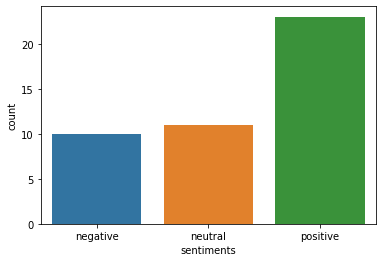

In [108]:
sns.countplot(access['sentiments'])

- More positive from access bank customers 

In [ ]:
#create a word_cloud function
def word_cloud(df):
    text = " ".join(review for review in df.text)

    stopwords = set(STOPWORDS)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

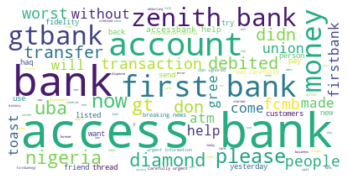

In [184]:
word_cloud(access)

## GTBank

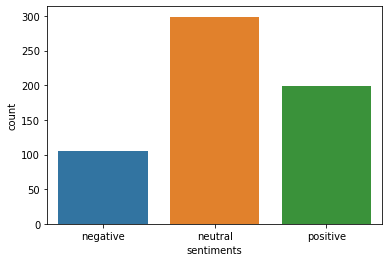

In [110]:
sns.countplot(gtb['sentiments'])

- Contains more tweet in the neutral category.

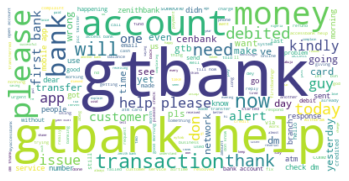

In [185]:
word_cloud(gtb)

## Zenith Bank

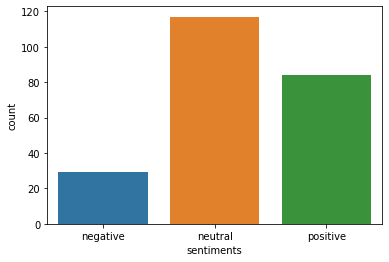

In [113]:
sns.countplot(zenith['sentiments'])

- Contains more neutral Tweets

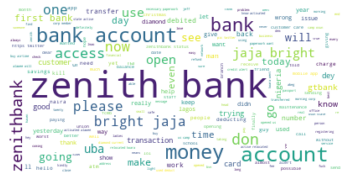

In [186]:
word_cloud(zenith)

## UBA 

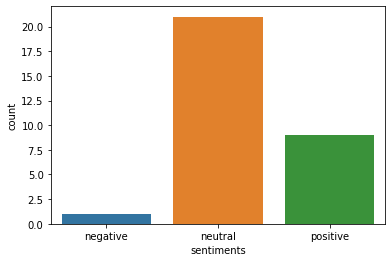

In [115]:
sns.countplot(uba['sentiments'])

- More Neutral Tweets

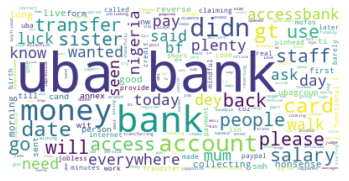

In [187]:
word_cloud(uba)

## FirstBank Plc

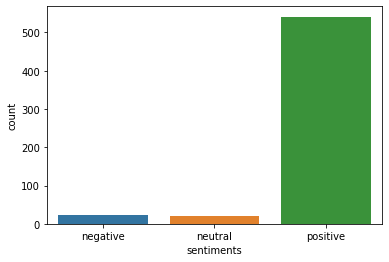

In [117]:
sns.countplot(firstbank['sentiments'])

- High number of positive tweets

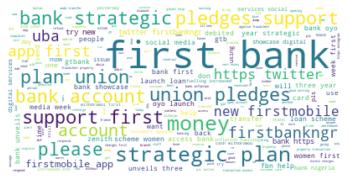

In [188]:
word_cloud(firstbank)

## Union Bank Plc

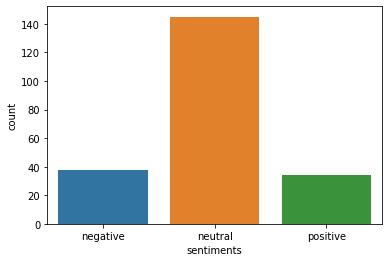

In [119]:
sns.countplot(union['sentiments'])

- More neutral tweets

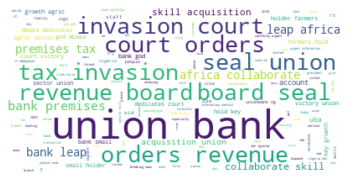

In [189]:
word_cloud(union)

## FCMB

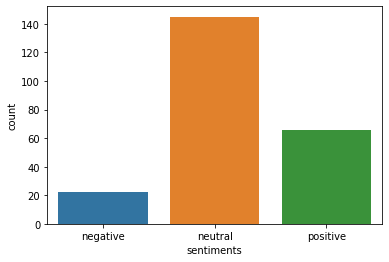

In [121]:
sns.countplot(fcmb['sentiments'])

- More neutral tweets

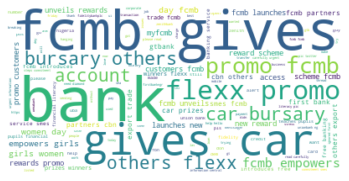

In [190]:
word_cloud(fcmb)